In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, make_scorer
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from bootstrapped.bootstrap import bootstrap
import bootstrapped.stats_functions as bs_stats
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Set Up

In [7]:

plt.rcParams.update({'font.size': 22})
analysis = 'Progression'
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)

def format_fun(analysis,name):
    load = "../Reference Files/FOR RF - {analysis} - {name}.csv".format(analysis=analysis, name=name)
    fdata0 = pd.read_csv(load)
    fdata = fdata0[fdata0['Progression'] != 'Med']
    fdata = fdata.drop('Sample',axis=1)
    fdata = fdata.drop('Status',axis=1)
    fdata = fdata.drop('Estimate',axis=1)

    le = LabelEncoder()
    fdata['Sex'] = le.fit_transform(fdata['Sex'])
    fdata[analysis] = le.fit_transform(fdata[analysis])
    
    fdata_var = fdata[["Progression",'Sex','bristol','coffee_per_day']] # Covariables only
    fdata_bac = fdata.drop('bristol',axis=1) # Bacteria
    fdata_bac = fdata_bac.drop('Sex',axis=1)
    fdata_bac = fdata_bac.drop('coffee_per_day',axis=1)

    ffiles = []
    ffiles.append(fdata_var)
    ffiles.append(fdata_bac)
    ffiles.append(fdata)

    ffilenames = ["Covar",name,"{name} & Covar".format(name=name)]
    results = [ffiles,ffilenames]
    return results

In [8]:
# Load Datasets

bac = format_fun(analysis, 'Taxonomy')
meta = format_fun(analysis, 'MetaCyc')
ko = format_fun(analysis, 'KO')
cog = format_fun(analysis, 'COG')
ec = format_fun(analysis, 'EC')

# Functions

In [9]:
# Plot ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def plot_output (all_true_labels_val, all_predicted_probabilities_val,all_true_labels_train, all_predicted_probabilities_train, ci_lower_train, ci_upper_train, ci_lower_val,ci_upper_val,dataset_name):
    # Calculate ROC curve
    fpr_val, tpr_val, _ = roc_curve(all_true_labels_val, all_predicted_probabilities_val)
    fpr_train, tpr_train, _ = roc_curve(all_true_labels_train, all_predicted_probabilities_train)

    # Calculate AUC
    roc_auc_val = auc(fpr_val, tpr_val)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr_train, tpr_train, color='black', linestyle='dotted', lw=2, label='Train: %0.2f (%0.2f-%0.2f)' % (roc_auc_train, ci_lower_train,ci_upper_train))
    plt.plot(fpr_val, tpr_val, color='black', lw=2, label='Test: %0.2f (%0.2f-%0.2f)' % (roc_auc_val, ci_lower_val,ci_upper_val))
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name}')
    plt.legend(loc='lower right')
   
    # Saving figure
    savename = "../Results/ROC Raw Figures/ROC Curve - {analysis} - {df}.png".format(analysis=analysis, df=dataset_name)
    
    plt.savefig(savename, format="png", bbox_inches="tight")

    plt.show()
    plt.close()

# Run Random Forest Analysis
def run_rf(data,data_name,analysis):
    
        print(f"Dataset: {data_name}")

        # Separate features (X) and target variable (y)
        X = data.drop(analysis, axis=1)
        y = data[analysis]

        # Folds for cross-validation
        skf = StratifiedKFold(n_splits=5)

        # Define lists to store AUC scores
        train_auc_scores = []
        test_auc_scores = []

        # Define lists
        all_true_labels_val = []
        all_predicted_probabilities_val = []
        all_true_labels_train = []
        all_predicted_probabilities_train = []
        feature_importance_values = []

        # Perform k-fold cross-validation
        for train_index, test_index in skf.split(X, y):
                X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[test_index]
                y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[test_index]

                # Train random forest model
                model_hyper = RandomForestClassifier(class_weight='balanced_subsample',random_state=124)

                # Hyperparameter tuning using Grid Search           
                param_grid = {
                        'n_estimators': [100,200],
                        'max_depth': [5,7,10],
                        'min_samples_leaf': [15,20],
                        'min_samples_split': [30,33,35],
                        'bootstrap': [True,False]
                }
                grid_search = GridSearchCV(
                        model_hyper, param_grid, cv=5, scoring=roc_scorer, n_jobs=-1
                )
                grid_search.fit(X_train_fold, y_train_fold)

                model=RandomForestClassifier(class_weight='balanced_subsample',random_state=124, **grid_search.best_params_)
                model.fit(X_train_fold, y_train_fold)

                # Statistics ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                # Calculate AUC on training set
                train_pred_proba = model.predict_proba(X_train_fold)[:, 1]
                train_auc = roc_auc_score(y_train_fold, train_pred_proba)
                train_auc_scores.append(train_auc)

                # Calculate AUC on validation set (test set)
                test_pred_proba = model.predict_proba(X_val_fold)[:, 1]
                test_auc = roc_auc_score(y_val_fold, test_pred_proba)
                test_auc_scores.append(test_auc)

                # Append true labels and predicted probabilities to lists
                all_true_labels_val.extend(y_val_fold)
                all_predicted_probabilities_val.extend(test_pred_proba)
                all_true_labels_train.extend(y_train_fold)
                all_predicted_probabilities_train.extend(train_pred_proba)

                # Append feature importance values from this tree to the list
                feature_importance_values.append(model.feature_importances_)

        # Bootstrap for uncertainty estimation
        bootstrapped_auc_val = bootstrap(np.array(test_auc_scores), stat_func=bs_stats.mean, num_iterations=1000)
        bootstrapped_auc_train = bootstrap(np.array(train_auc_scores), stat_func=bs_stats.mean, num_iterations=1000)

        # Extract bootstrapped statistic values
        bootstrapped_value_val = bootstrapped_auc_val.value
        ci_lower_val = bootstrapped_auc_val.lower_bound
        ci_upper_val = bootstrapped_auc_val.upper_bound

        bootstrapped_value_train = bootstrapped_auc_train.value
        ci_lower_train = bootstrapped_auc_train.lower_bound
        ci_upper_train = bootstrapped_auc_train.upper_bound

        # Feature Importance
        mean_feature_importance = np.mean(feature_importance_values, axis=0)        
        importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': mean_feature_importance
        })
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        # Create plot
        plot_output(all_true_labels_val, all_predicted_probabilities_val,all_true_labels_train, all_predicted_probabilities_train, ci_lower_train, ci_upper_train, ci_lower_val,ci_upper_val,data_name)

        # Save Statistics
        temp = pd.DataFrame({
        'Dataset': [data_name],
        'Analysis': [analysis],
        'Training AUC': [round(bootstrapped_value_train,2)],
        'Training AUC CI': ["{low}-{high}".format(low=round(ci_lower_train,2),high=round(ci_upper_train,2))],
        'Testing AUC': [round(bootstrapped_value_val,2)],
        'Testing AUC CI': ["{low}-{high}".format(low=round(ci_lower_val,2),high=round(ci_upper_val,2))]
        },index=[0])

        results = [temp,importance_df]
        return results

# Run RF On Datasets

Dataset: Covar


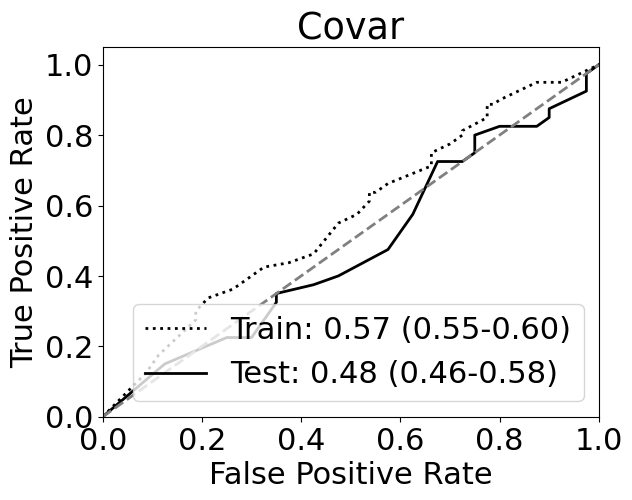

Dataset: Taxonomy


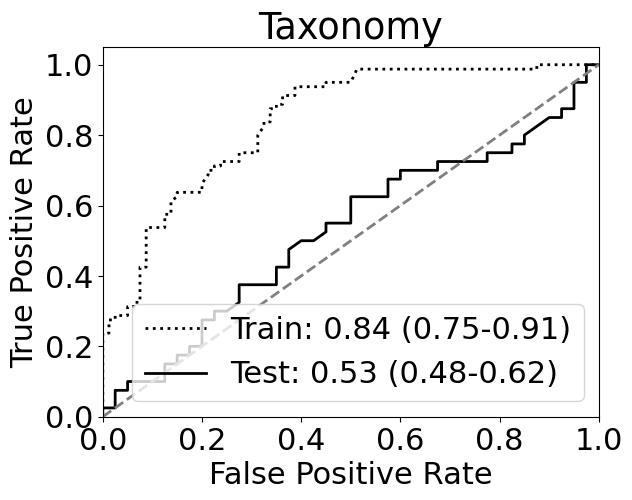

Dataset: Taxonomy & Covar


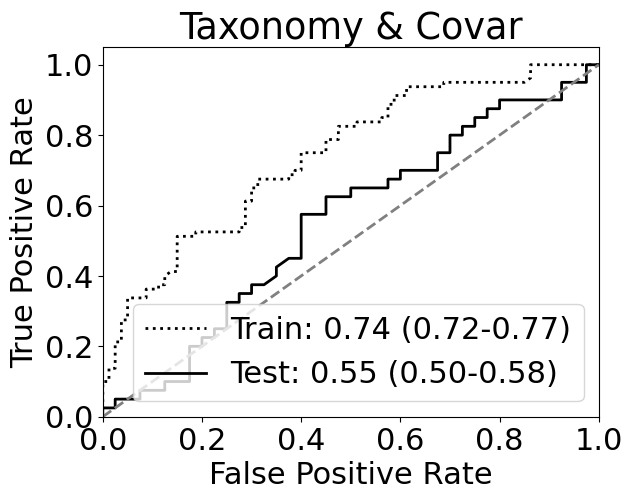

Dataset: MetaCyc


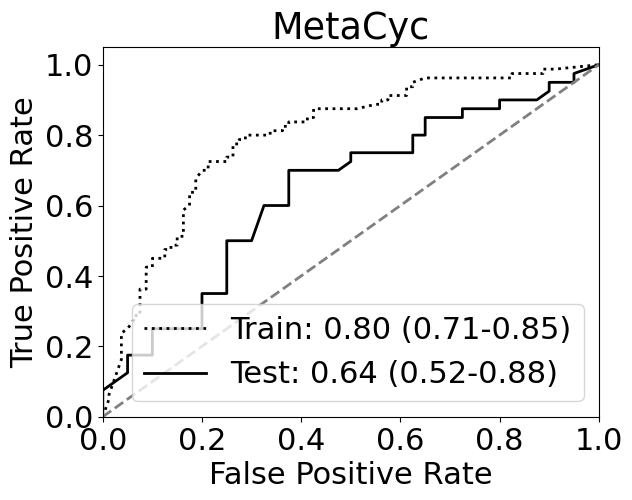

Dataset: MetaCyc & Covar


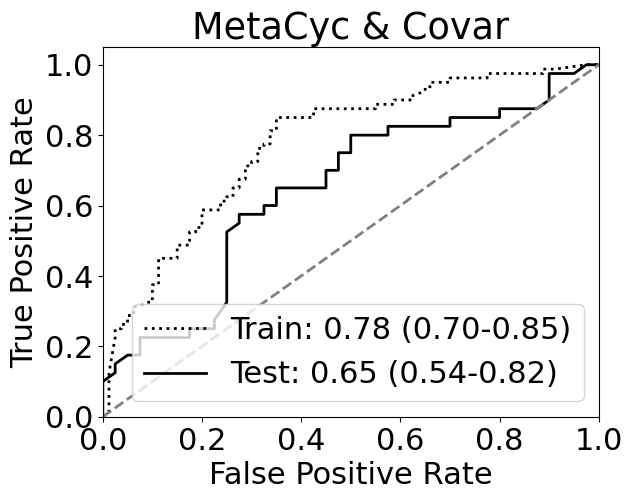

Dataset: EC


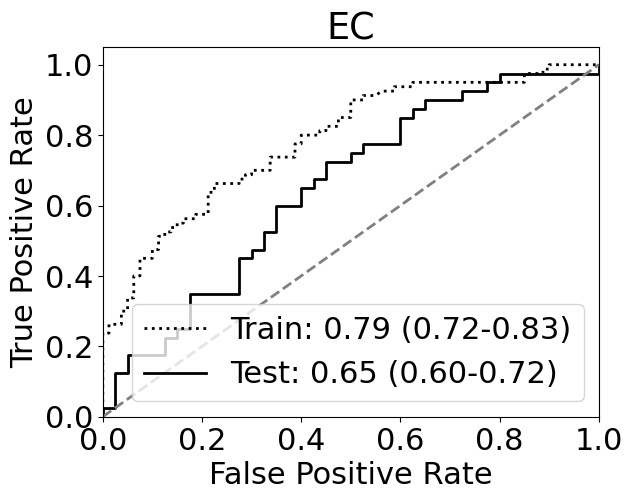

Dataset: EC & Covar


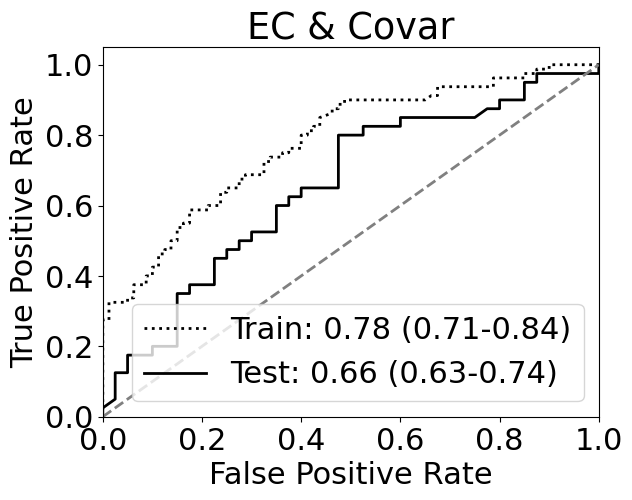

Dataset: KO


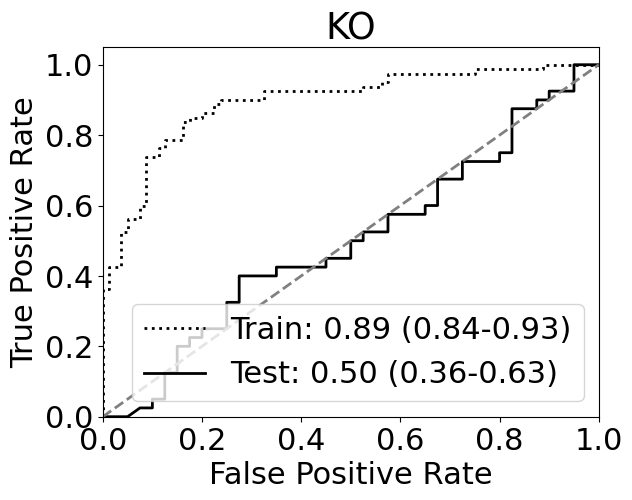

Dataset: KO & Covar


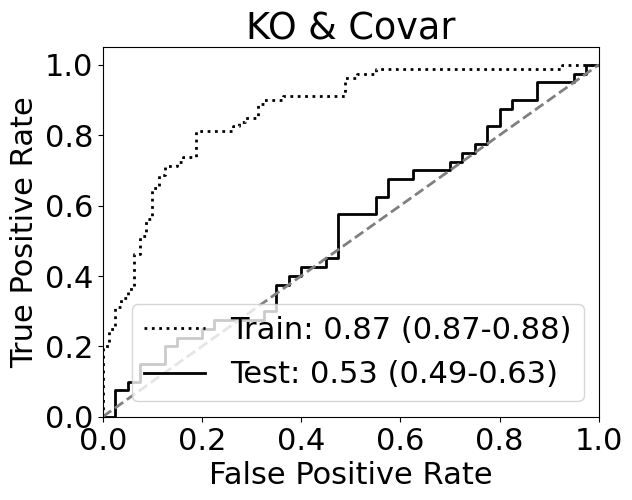

Dataset: COG


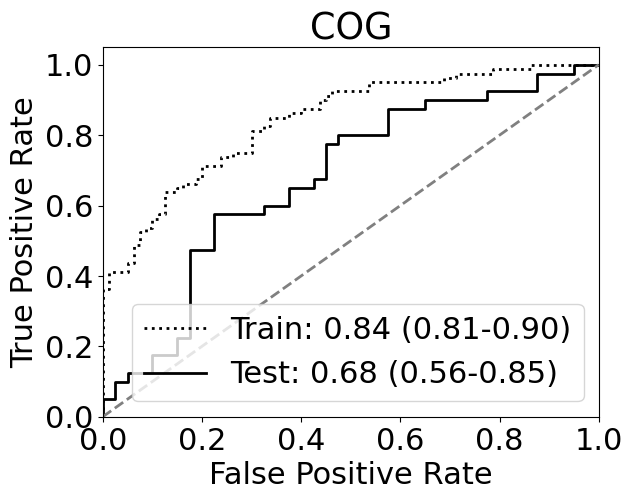

Dataset: COG & Covar


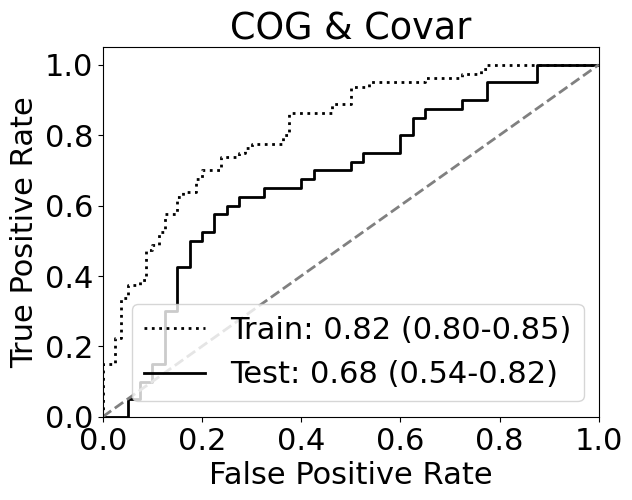

In [10]:
# Covars
data = bac[0][0]
name = bac[1][0]
covars = run_rf(data=data,data_name=name,analysis='Progression')

# Taxonomy
data = bac[0][1]
name = bac[1][1]
taxonomy = run_rf(data=data,data_name=name,analysis='Progression')

# Taxonomy & Covars
data = bac[0][2]
name = bac[1][2]
tax_cov = run_rf(data=data,data_name=name,analysis='Progression')

# MetaCyc
data = meta[0][1]
name = meta[1][1]
metacyc = run_rf(data=data,data_name=name,analysis='Progression')

# MetaCyc & Covars
data = meta[0][2]
name = meta[1][2]
meta_cov = run_rf(data=data,data_name=name,analysis='Progression')

# EC
data = ec[0][1]
name = ec[1][1]
EC = run_rf(data=data,data_name=name,analysis='Progression')

# EC & Covars
data = ec[0][2]
name = ec[1][2]
ec_cov = run_rf(data=data,data_name=name,analysis='Progression')

# KO
data = ko[0][1]
name = ko[1][1]
KO = run_rf(data=data,data_name=name,analysis='Progression')

# KO & Covars
data = ko[0][2]
name = ko[1][2]
ko_cov = run_rf(data=data,data_name=name,analysis='Progression')

# COG
data = cog[0][1]
name = cog[1][1]
COG = run_rf(data=data,data_name=name,analysis='Progression')

# COG & Covars
data = cog[0][2]
name = cog[1][2]
cog_cov = run_rf(data=data,data_name=name,analysis='Progression')

# Save Importance Values and Stats

In [6]:
# Save importance values
name = "../Results/Supplementary Data/Random Forest/RF Importance Values - {analysis}.xlsx".format(analysis=analysis)
writer=pd.ExcelWriter(name)

covars[1].to_excel(writer,sheet_name="Covars")

taxonomy[1].to_excel(writer,sheet_name="Taxonomy")
tax_cov[1].to_excel(writer,sheet_name="Taxonomy & Covars")

metacyc[1].to_excel(writer,sheet_name="MetaCyc")
meta_cov[1].to_excel(writer,sheet_name="MetaCyc & Covars")

EC[1].to_excel(writer,sheet_name="EC")
ec_cov[1].to_excel(writer,sheet_name="EC & Covars")

KO[1].to_excel(writer,sheet_name="KO")
ko_cov[1].to_excel(writer,sheet_name="KO & Covars")

COG[1].to_excel(writer,sheet_name="COG")
cog_cov[1].to_excel(writer,sheet_name="COG & Covars")

writer.close()


# Save statistics
temp = [covars[0],taxonomy[0],tax_cov[0],metacyc[0],meta_cov[0],EC[0],ec_cov[0],KO[0],ko_cov[0],COG[0],cog_cov[0]]
comb_temp = pd.concat(temp,axis=0)
comb_temp.reset_index(drop=True, inplace=True)

name = "../Results/Supplementary Data/Random Forest/RF Statistics - {analysis}.xlsx".format(analysis=analysis)
writer=pd.ExcelWriter(name)
comb_temp.to_excel(writer,sheet_name="RF AUC Values")
writer.close()